## Dimensions
1. Number of clusters (3,5,7,9)
2. Cluster validity index (DBIndex, Silhoutte Index, Dunn Index)
3. Algorithms (Genetic, Particle Swarm, Particle Gray Wolf)
4. Datasets (BBC, BBC Sports, Reuters, 20 newsgroup, etc.)

In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Time to pre-process1.046875
[[ 0.67520873 -0.28222328  0.68150069]
 [ 0.92869772  0.12674412  0.34850605]
 [ 0.64738382 -0.28096875  0.70848483]
 ...
 [ 0.81430251 -0.2216521   0.53645295]
 [ 0.96800499 -0.19015783  0.16372638]
 [ 0.82963466 -0.11266325  0.54682111]]


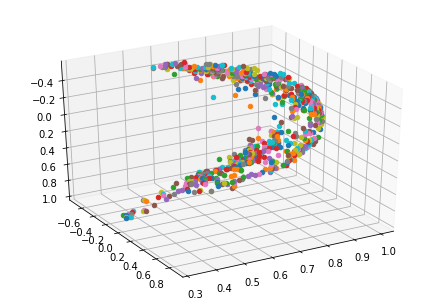

In [2]:
all_texts=[]
Y = []
start = time.process_time()
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbcsport")
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbc")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GA")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process"+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
ax = Axes3D(fig)
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 120)

In [3]:
K=7
P=30
cross_over_rate=0.1
mutation_rate=0.01
number_of_generations=100

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        P chromosomes of length K*N where N is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated P times
    '''
    population=[]
    for i in range(P):
        chromosome=[]
        for j in range(K):
            chromosome.append(X[random.randint(0,len(X)-1)])
        chromosome=list(itertools.chain(*chromosome))
        population.append(chromosome)
    return population

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(chromosome):
    '''
    Parameters:
        K: Number of clusters
        chromosome: Contains the centers of K clusters
        X : dataset
    Output:
        A fitness value f for the input chromosome
    Function:
        1. Initializes K centers using the chromosome
        2. Divides the dataset into K clusters using functions like cosine_similarity or euclidean_distance
        3. Recomputer cluster centers by averaging the datapoints of that cluster
        4. Computer fitness value as follows:
                M = sum from i in range(1,K)(Mi)
                Mi= sum of distances of datapoints of a cluster from its center
                fitness_value(f) = 1/M
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
    
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
        
    #Recomputing cluster centers
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    chromosome =[]
    for i in range(len(centers)):
        chromosome.extend(centers[i])
    fitness_score = theta
    return fitness_score,chromosome        

In [8]:
def fitness_evaluation(population):
    '''
    Parameters:
        K: Number of clusters
        population: Contains all the chromosomes of the current generation
        X : dataset
    Output:
        A list of fitness scores of each chromosome in the parent
    '''
    fitness=[]
    pop = []
    for i in population:
        fitness_value,recomputed_chromosome = fitness_function(i)
        fitness.append(fitness_value)
        pop.append(recomputed_chromosome)
    return pop,fitness

In [9]:
def roulette_wheel(fitness_scores):
    sum_fitness_scores = np.sum(np.asarray(fitness_scores))
    temp_fitness = copy.deepcopy(fitness_scores)
    temp_fitness.sort(reverse=True)
    t=[]
    for i in range(len(fitness_scores)):
        percentage_coverage=int(temp_fitness[i]*360/sum_fitness_scores)
        for j in range(percentage_coverage):
            t.append(i)
    
    temp=[]
    for i in range(2):
        toss=random.randint(0,len(t)-1)
        temp.append(t[toss])
    return temp

In [10]:
def cross_over(parent1,parent2,parent1_f_val,parent2_f_val):
    temp = {}
    fitness_scores=[]
    fitness_scores.append(parent1_f_val)
    fitness_scores.append(parent2_f_val)
    temp[parent1_f_val]=parent1
    temp[parent2_f_val]=parent2
    for i in range(1,len(parent1)-1):
        prob_of_cross_over_point = np.random.random_sample()
        if prob_of_cross_over_point<cross_over_rate:
            left_parent_1 = parent1[:i]
            right_parent_1= parent1[i:]
            left_parent_2 = parent2[:i]
            right_parent_2= parent2[i:]
            child1 = left_parent_1
            child2 = left_parent_2
            child1.extend(right_parent_2)
            child2.extend(right_parent_1)
            _,fitness_values = fitness_evaluation([child1,child2])
            temp[fitness_values[0]]=child1
            temp[fitness_values[1]]=child2
            fitness_scores.extend(fitness_values)
    max1=max(fitness_scores)
    fitness_scores.remove(max1)
    max2=max(fitness_scores)
    return temp[max1],temp[max2]

In [11]:
def cross_over_function(population,fitness_scores):
    '''
    Parameters:
        population: Parent population chromosomes
        fitness_scores: fitness of parent population
    Output:
        children generation population
    Function:
        We select the 2 best chromosomes and 2 worst chromosomes and perform a cross-over between the bests and worsts and add
        them to the population generating children generation population with 4 different chromosomes.
    '''
    for i in range(P//2):
        t=roulette_wheel(fitness_scores)
        t.sort()
        c1i,c2i=t[0:2]
        chromosome1 = population[c1i]
        chromosome2 = population[c2i]

        c1,c2 = cross_over(chromosome1,chromosome2,fitness_scores[c1i],fitness_scores[c2i])

        population.append(c1)
        population.append(c2)

        del(population[c1i])
        del(fitness_scores[c1i])
        c2i=max(0,c2i-1)
        del(population[c2i])
        del(fitness_scores[c2i])

        t,fitness = fitness_evaluation([c1,c2])
        fitness_scores.extend(fitness)
    return population,fitness_scores

In [12]:
def mutation(children):
    '''
    Parameters:
        children: Children we get from the genetic cross-over in the previous stage
        mutation_rate: Rate at which we want to mutate the children (0-1)
    Output:
        children with a mutated gene
    Functions:
        We randomly select a number between 0 and 1 using probably a gaussian distribution as mutation is not a frequent
        phenomenon. If that value is less than mutation_rate we mutate the children.
        For mutation we again generate a value alpha between 0 to 1. We then randomly select a position from the chromosome
        and changes its value as following
            let the value at the randomly selected position be v
            v = v (+/-) 2*alpha*v if(v!=0)
            v = v (+/-) 2*alpha   if(v==0)
        (+/-) is selected randomly giving each a 50-50 chance
    '''
    for i in range(len(children)):
        temp = np.random.rand(1)[0]
        if temp<mutation_rate:
            chromosome = children[i]
            position = random.randint(0,len(chromosome)-1)
            chromosome[position]=abs(1-chromosome[position])
            children[i]=chromosome
            
    return children

In [13]:
def intracluster_distances(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(chromosome):
    intra_distance = intracluster_distances(chromosome)
    
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def dunn_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(chromosome))
    return numerator/denominator

In [17]:
def supervised_scores(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(cosine_similarity(centers,X[i]))
#         Y_pred.append(euclidean_dist_based_center_decision(centers,X[i]))
    
    print(confusion_matrix(Y, Y_pred))
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [18]:
def main_func():
    '''
    Steps:
    Repeat 1-5 till 1 chromosome remains in the population
    1.Initialize Population
    2.Compute fitness scores
    3.Selection
    4.Cross-over
    5.Mutation
    '''
    start = time.process_time()
    population = population_initialization()
    gen=0
    return_chromosome=[]
    gen_fitness = []
    for i in range(number_of_generations):
        gen+=1
        population,fitness=fitness_evaluation(population)
        children,fitness = cross_over_function(population,fitness)
        children = mutation(children)
        population=children
        temp = []
        temp.append(str(gen))
        temp.append(str(max(fitness)))
        gen_fitness.append(temp)
        print("Generation: "+str(gen)+" | Best fitness: "+str(max(fitness)))
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GA with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return population[fitness.index(max(fitness))]

In [19]:
def plot(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#333333','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 120)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation: 1 | Best fitness: 10.819940114226013
Generation: 2 | Best fitness: 10.819940114226002
Generation: 3 | Best fitness: 10.41547301682861
Generation: 4 | Best fitness: 9.736769613397252
Generation: 5 | Best fitness: 11.229565494236548
Generation: 6 | Best fitness: 10.034539142427125
Generation: 7 | Best fitness: 11.120100550066782
Generation: 8 | Best fitness: 11.120100550066802
Generation: 9 | Best fitness: 10.38286065746357
Generation: 10 | Best fitness: 12.774839624290511
Generation: 11 | Best fitness: 12.774839624290502
Generation: 12 | Best fitness: 10.337887772614552
Generation: 13 | Best fitness: 10.504631561843023
Generation: 14 | Best fitness: 10.50381462829226
Generation: 15 | Best fitness: 12.645731483928566
Generation: 16 | Best fitness: 10.278358878690652
Generation: 17 | Best fitness: 10.277623458338212
Generation: 18 | Best fitness: 11.523698816386013
Generation: 19 | Best fitness: 9.288437735496451
Generation: 20 | Best fitness: 9.288437735496435
Generation: 21 

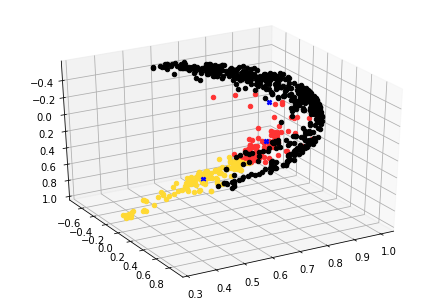

In [20]:
K = 3
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# F1, Accuracy = supervised_scores(chromosome)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 19.580268601206715


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 2 | Best fitness: 20.584320591640008
Generation: 3 | Best fitness: 34.10670225256321
Generation: 4 | Best fitness: 18.025101833438207
Generation: 5 | Best fitness: 30.07696335493506
Generation: 6 | Best fitness: 27.77390189850992
Generation: 7 | Best fitness: 31.550536022553413
Generation: 8 | Best fitness: 28.36397172389981
Generation: 9 | Best fitness: 30.96956968299572
Generation: 10 | Best fitness: 18.39280912241623
Generation: 11 | Best fitness: 28.53449721804735


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 12 | Best fitness: 27.788859381362876
Generation: 13 | Best fitness: 30.752893660989713
Generation: 14 | Best fitness: 30.483892229894156
Generation: 15 | Best fitness: 21.838045113162796
Generation: 16 | Best fitness: 21.632727880304692
Generation: 17 | Best fitness: 26.01386026803232
Generation: 18 | Best fitness: 33.47246467171815


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 19 | Best fitness: 27.329286002646157
Generation: 20 | Best fitness: 32.651185394699844
Generation: 21 | Best fitness: 31.002825308587873
Generation: 22 | Best fitness: 32.6223794403189
Generation: 23 | Best fitness: 32.622379440318944
Generation: 24 | Best fitness: 25.23875107520563
Generation: 25 | Best fitness: 27.389823232680435
Generation: 26 | Best fitness: 27.38982323268042


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 27 | Best fitness: 16.957288575219188
Generation: 28 | Best fitness: 30.574536903000535
Generation: 29 | Best fitness: 30.5745369030006
Generation: 30 | Best fitness: 24.730136763334976
Generation: 31 | Best fitness: 18.9470276561843
Generation: 32 | Best fitness: 27.629022953404487
Generation: 33 | Best fitness: 27.629022953404476
Generation: 34 | Best fitness: 23.742478483109096


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 35 | Best fitness: 30.366148938879146
Generation: 36 | Best fitness: 30.366148938879157
Generation: 37 | Best fitness: 18.831714934589165
Generation: 38 | Best fitness: 20.478189097532493
Generation: 39 | Best fitness: 22.803693897149362
Generation: 40 | Best fitness: 22.703678600097305
Generation: 41 | Best fitness: 22.703678600097273
Generation: 42 | Best fitness: 30.534469867731886
Generation: 43 | Best fitness: 22.80710558991253
Generation: 44 | Best fitness: 16.18733711819709
Generation: 45 | Best fitness: 20.311736908203944
Generation: 46 | Best fitness: 29.317503893279397
Generation: 47 | Best fitness: 29.31750389327942
Generation: 48 | Best fitness: 18.637593521153356
Generation: 49 | Best fitness: 21.39417934635857
Generation: 50 | Best fitness: 18.74285364984751
Generation: 51 | Best fitness: 18.742853649847476
Generation: 52 | Best fitness: 14.637837237848766
Generation: 53 | Best fitness: 17.396497686343096
Generation: 54 | Best fitness: 18.79413218896604
Genera

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 70 | Best fitness: 14.300118304563009
Generation: 71 | Best fitness: 14.53124568909898
Generation: 72 | Best fitness: 14.531245689099013
Generation: 73 | Best fitness: 13.859997255581323
Generation: 74 | Best fitness: 13.859997255581314
Generation: 75 | Best fitness: 15.403856073784304
Generation: 76 | Best fitness: 13.430655631510142
Generation: 77 | Best fitness: 13.922229781223896
Generation: 78 | Best fitness: 15.903089017117438
Generation: 79 | Best fitness: 15.578149958559337
Generation: 80 | Best fitness: 14.635079575366051
Generation: 81 | Best fitness: 14.635079575366039
Generation: 82 | Best fitness: 13.722821020499385
Generation: 83 | Best fitness: 13.275873445020194
Generation: 84 | Best fitness: 15.668890126001813
Generation: 85 | Best fitness: 15.668890126001806
Generation: 86 | Best fitness: 14.816981129268799
Generation: 87 | Best fitness: 14.783359191686758
Generation: 88 | Best fitness: 12.20209067275867
Generation: 89 | Best fitness: 11.841469552348602
Ge

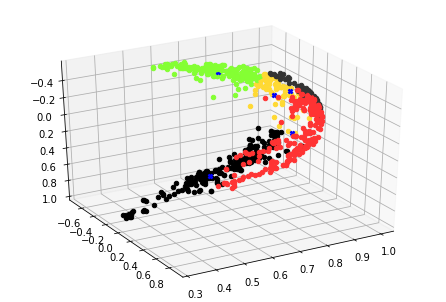

In [21]:
K = 5
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# F1, Accuracy = supervised_scores(chromosome)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 55.30536612860517


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 2 | Best fitness: 47.89016399505622
Generation: 3 | Best fitness: 53.38226640566262
Generation: 4 | Best fitness: 40.662529691919815
Generation: 5 | Best fitness: 55.27205386290092
Generation: 6 | Best fitness: 55.27205386290081
Generation: 7 | Best fitness: 43.82735460803364
Generation: 8 | Best fitness: 27.563027005219965
Generation: 9 | Best fitness: 58.03924237699975
Generation: 10 | Best fitness: 58.03924237699977
Generation: 11 | Best fitness: 43.386128271789545
Generation: 12 | Best fitness: 51.708632977773384
Generation: 13 | Best fitness: 51.708632977773384
Generation: 14 | Best fitness: 32.16248909904187
Generation: 15 | Best fitness: 32.162489099041835
Generation: 16 | Best fitness: 24.136267713139777
Generation: 17 | Best fitness: 46.03949233221087
Generation: 18 | Best fitness: 25.304808632122732
Generation: 19 | Best fitness: 31.09277791967427
Generation: 20 | Best fitness: 39.4953296414737
Generation: 21 | Best fitness: 54.18748977370404
Generation: 22 | Best

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 30 | Best fitness: 39.54343981166676
Generation: 31 | Best fitness: 27.372109317974356
Generation: 32 | Best fitness: 27.372109317974363
Generation: 33 | Best fitness: 26.034273962024187
Generation: 34 | Best fitness: 25.98817866701907
Generation: 35 | Best fitness: 45.5865149294755
Generation: 36 | Best fitness: 44.06220474565266
Generation: 37 | Best fitness: 35.08004167074839
Generation: 38 | Best fitness: 24.581423975000487
Generation: 39 | Best fitness: 48.75462965372608
Generation: 40 | Best fitness: 48.75462965372606
Generation: 41 | Best fitness: 25.285705536370035


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 42 | Best fitness: 26.293232553972807


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 43 | Best fitness: 27.26399830140555
Generation: 44 | Best fitness: 44.535202706128516
Generation: 45 | Best fitness: 50.17036841395655
Generation: 46 | Best fitness: 44.24357762635402
Generation: 47 | Best fitness: 27.854094029536306


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 48 | Best fitness: 32.75463121534337
Generation: 49 | Best fitness: 55.57731517626795
Generation: 50 | Best fitness: 51.24409416071045
Generation: 51 | Best fitness: 49.78584057989791
Generation: 52 | Best fitness: 49.785840579897936


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 53 | Best fitness: 44.5996616972983


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 54 | Best fitness: 44.599661697298195
Generation: 55 | Best fitness: 26.121360051523677
Generation: 56 | Best fitness: 45.10525888118736


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 57 | Best fitness: 45.85673928241699


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 58 | Best fitness: 45.856739282417124
Generation: 59 | Best fitness: 50.371303431795404


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 60 | Best fitness: 49.633437952780106
Generation: 61 | Best fitness: 48.38975692200322
Generation: 62 | Best fitness: 45.00766177211282
Generation: 63 | Best fitness: 41.2307805572622
Generation: 64 | Best fitness: 45.6693088126854
Generation: 65 | Best fitness: 50.02846263620217
Generation: 66 | Best fitness: 49.62617641346519
Generation: 67 | Best fitness: 29.209232584422136
Generation: 68 | Best fitness: 35.55705342330249
Generation: 69 | Best fitness: 50.844264230839364


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 70 | Best fitness: 46.23673672091003
Generation: 71 | Best fitness: 47.782731765841824
Generation: 72 | Best fitness: 25.306750275459468
Generation: 73 | Best fitness: 41.785190709400126


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 74 | Best fitness: 41.785190709400105
Generation: 75 | Best fitness: 24.99259145226862
Generation: 76 | Best fitness: 45.745813032998825
Generation: 77 | Best fitness: 40.558055662039834
Generation: 78 | Best fitness: 45.303817254829475
Generation: 79 | Best fitness: 45.30381725482948
Generation: 80 | Best fitness: 39.95221548598589
Generation: 81 | Best fitness: 54.90404638052144
Generation: 82 | Best fitness: 29.087896985979068
Generation: 83 | Best fitness: 47.095859501318294
Generation: 84 | Best fitness: 46.09482279690989
Generation: 85 | Best fitness: 45.051611601174876
Generation: 86 | Best fitness: 45.05161160117491
Generation: 87 | Best fitness: 38.168308352002384
Generation: 88 | Best fitness: 36.47361267383111


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 89 | Best fitness: 40.89707885487183


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 90 | Best fitness: 51.0718751713273


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 91 | Best fitness: 48.241776159339835
Generation: 92 | Best fitness: 44.43120550571043
Generation: 93 | Best fitness: 56.385348514793634
Generation: 94 | Best fitness: 49.63193279051652
Generation: 95 | Best fitness: 42.0984408101402
Generation: 96 | Best fitness: 40.152535844857425
Generation: 97 | Best fitness: 43.685984571885676
Generation: 98 | Best fitness: 44.5301506087672
Generation: 99 | Best fitness: 46.032440157210075
Generation: 100 | Best fitness: 42.83667699328679
Time taken: 1544.109375
DB Index        :0.86479559623758
Silhoutte Index :0.9456491898075453
67
61
203
137
56
109
104


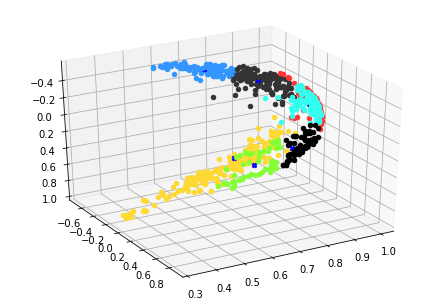

In [22]:
K = 7
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 1 | Best fitness: 34.88941217943701


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 2 | Best fitness: 34.889412179437066


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 3 | Best fitness: 49.58668232618251


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 4 | Best fitness: 49.79443516741518
Generation: 5 | Best fitness: 57.76258309398111
Generation: 6 | Best fitness: 53.52509617890914
Generation: 7 | Best fitness: 44.226469693110545
Generation: 8 | Best fitness: 44.226469693110545
Generation: 9 | Best fitness: 36.72874108044853


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 10 | Best fitness: 36.72874108044846
Generation: 11 | Best fitness: 54.35905675397469


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 12 | Best fitness: 54.98159839258667
Generation: 13 | Best fitness: 54.98159839258677
Generation: 14 | Best fitness: 34.80456912938949
Generation: 15 | Best fitness: 70.37289432025099
Generation: 16 | Best fitness: 68.06160565902907


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 17 | Best fitness: 34.97450021883126
Generation: 18 | Best fitness: 35.934969042967644
Generation: 19 | Best fitness: 55.62074016629074
Generation: 20 | Best fitness: 67.15789395765474
Generation: 21 | Best fitness: 61.06894461784128
Generation: 22 | Best fitness: 51.563344335815


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 23 | Best fitness: 35.23406463752363
Generation: 24 | Best fitness: 50.23431775158154


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 25 | Best fitness: 50.23431775158158
Generation: 26 | Best fitness: 65.13283358211308


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 27 | Best fitness: 36.37571477502872
Generation: 28 | Best fitness: 35.20183341207559
Generation: 29 | Best fitness: 33.696274542699044
Generation: 30 | Best fitness: 72.21018137924396


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 31 | Best fitness: 72.21018137924365


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 32 | Best fitness: 78.10702639442958
Generation: 33 | Best fitness: 78.10702639442955
Generation: 34 | Best fitness: 88.04420487093566
Generation: 35 | Best fitness: 57.184366083068916
Generation: 36 | Best fitness: 86.4673169980211


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 37 | Best fitness: 86.4673169980212
Generation: 38 | Best fitness: 65.04298099457324
Generation: 39 | Best fitness: 63.634623638817025
Generation: 40 | Best fitness: 33.15851911105083
Generation: 41 | Best fitness: 79.86085372117093
Generation: 42 | Best fitness: 74.49007072931987
Generation: 43 | Best fitness: 31.06986417349868
Generation: 44 | Best fitness: 60.51575617827036
Generation: 45 | Best fitness: 32.90910888404169
Generation: 46 | Best fitness: 36.119831634581324
Generation: 47 | Best fitness: 34.18487057617165
Generation: 48 | Best fitness: 40.41438300613984
Generation: 49 | Best fitness: 50.13801174556641
Generation: 50 | Best fitness: 64.86212384893534
Generation: 51 | Best fitness: 66.21558051556363
Generation: 52 | Best fitness: 66.21558051556478
Generation: 53 | Best fitness: 85.43075128765888
Generation: 54 | Best fitness: 58.42147893883071
Generation: 55 | Best fitness: 34.8104431430448
Generation: 56 | Best fitness: 32.63656246350586
Generation: 57 | Bes

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 84 | Best fitness: 35.32187731590539
Generation: 85 | Best fitness: 35.64323656177396
Generation: 86 | Best fitness: 36.20949060206426


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 87 | Best fitness: 35.50285504101071
Generation: 88 | Best fitness: 35.50285504101068
Generation: 89 | Best fitness: 35.32187731590534
Generation: 90 | Best fitness: 35.321877315905276
Generation: 91 | Best fitness: 35.62437950638196
Generation: 92 | Best fitness: 35.62437950638196
Generation: 93 | Best fitness: 35.321877315905304
Generation: 94 | Best fitness: 35.32187731590534
Generation: 95 | Best fitness: 35.32187731590534
Generation: 96 | Best fitness: 35.32187731590526
Generation: 97 | Best fitness: 36.29490047047952
Generation: 98 | Best fitness: 36.295766225904934
Generation: 99 | Best fitness: 37.85786151102215
Generation: 100 | Best fitness: 35.32187731590533
Time taken: 2014.125
DB Index        :0.9321034098101961
Silhoutte Index :0.9501538713608468
83
177
55
69
31
38
35
192
57


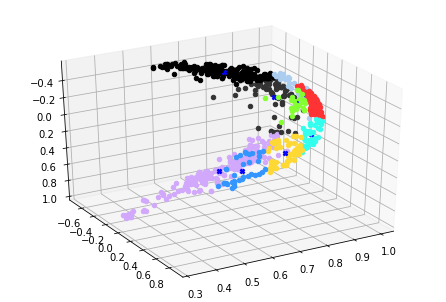

In [23]:
K = 9
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)